In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- 1. Define Parameters (Định nghĩa tham số) ---
C_m = 1.0          # uF/cm^2 (Điện dung màng)
g_Na = 120.0       # mS/cm^2 (Độ dẫn Na tối đa)
g_K = 36.0         # mS/cm^2 (Độ dẫn K tối đa)
g_L = 0.3          # mS/cm^2 (Độ dẫn rò)

E_Na = 50.0        # mV (Thế đảo Na)
E_K = -77.0        # mV (Thế đảo K)
E_L = -54.387      # mV (Thế đảo rò - được chỉnh để V_rest = -65mV)

# --- 2. Define Rate Functions (6 hàm tốc độ) ---
# Lưu ý: Các công thức này được chuẩn hóa cho V tính bằng mV
# EPSILON dùng để tránh lỗi chia cho 0 tại các điểm kỳ dị (singularity)
EPSILON = 1e-9

def alpha_n(V):
    return 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0) + EPSILON)

def beta_n(V):
    return 0.125 * np.exp(-(V + 65.0) / 80.0)

def alpha_m(V):
    return 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0) + EPSILON)

def beta_m(V):
    return 4.0 * np.exp(-(V + 65.0) / 18.0)

def alpha_h(V):
    return 0.07 * np.exp(-(V + 65.0) / 20.0)

def beta_h(V):
    return 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))

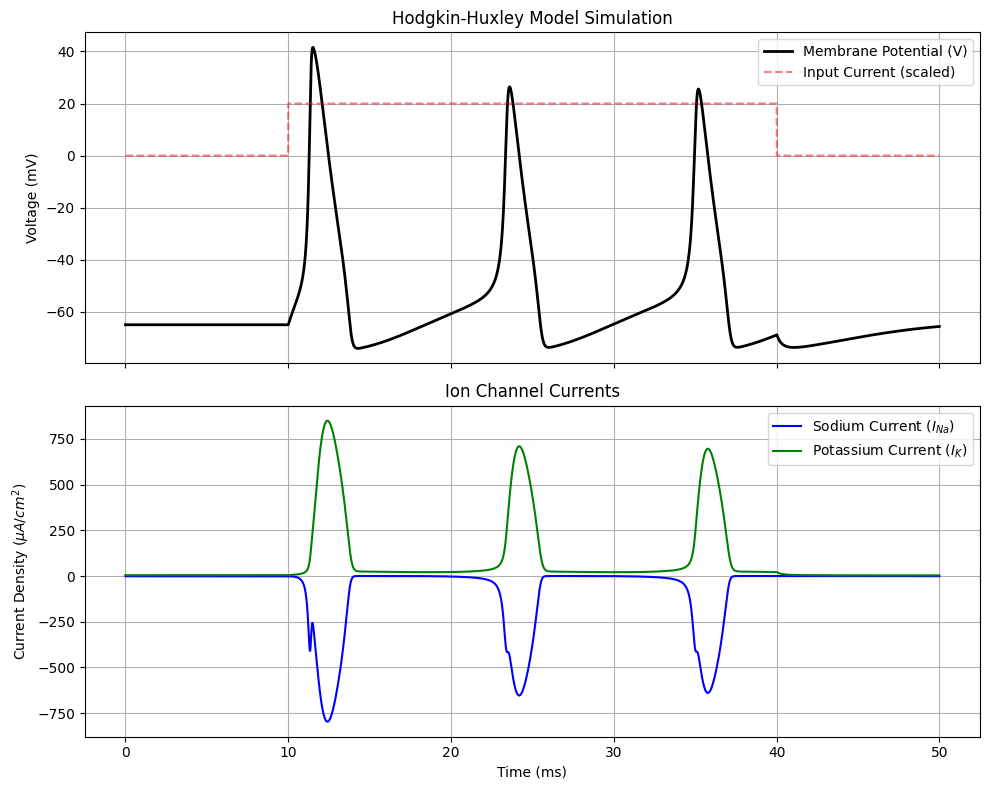

In [3]:
# --- 3. Simulation Setup (Thiết lập mô phỏng) ---
dt = 0.01          # Bước thời gian (ms)
T = 50.0           # Tổng thời gian mô phỏng (ms)
t = np.arange(0, T, dt)

# Mảng lưu trữ kết quả
V = np.zeros(len(t))
m = np.zeros(len(t))
h = np.zeros(len(t))
n = np.zeros(len(t))

I_Na_trace = np.zeros(len(t)) # Để vẽ đồ thị dòng điện
I_K_trace = np.zeros(len(t))

# Dòng điện kích thích (Step Input Requirement: 20 uA/cm^2)
I_x = np.zeros(len(t))
start_stim = 10.0  # Bắt đầu kích thích tại 10ms
end_stim = 40.0    # Kết thúc tại 40ms
I_x[(t >= start_stim) & (t <= end_stim)] = 20.0 

# --- 4. Initial Conditions (Điều kiện ban đầu) ---
# Requirement: V0 = -65 mV
V[0] = -65.0
# Tính giá trị ổn định (steady state) cho m, h, n tại V0
# Công thức: x_inf = alpha / (alpha + beta)
m[0] = alpha_m(V[0]) / (alpha_m(V[0]) + beta_m(V[0]))
h[0] = alpha_h(V[0]) / (alpha_h(V[0]) + beta_h(V[0]))
n[0] = alpha_n(V[0]) / (alpha_n(V[0]) + beta_n(V[0]))

# --- 5. Main Loop (Vòng lặp giải thuật toán) ---
for i in range(1, len(t)):
    # Lấy giá trị tại bước trước
    V_old = V[i-1]
    m_old = m[i-1]
    h_old = h[i-1]
    n_old = n[i-1]
    
    # Tính các dòng điện ion (để lưu trữ và dùng cho update V)
    I_Na = g_Na * (m_old**3) * h_old * (V_old - E_Na)
    I_K = g_K * (n_old**4) * (V_old - E_K)
    I_L = g_L * (V_old - E_L)
    
    # Lưu giá trị dòng điện để vẽ đồ thị
    I_Na_trace[i-1] = I_Na
    I_K_trace[i-1] = I_K
    
    # Cập nhật V (Phương trình màng)
    # dV/dt = (I_ext - I_ion) / Cm
    dVdt = (I_x[i-1] - (I_Na + I_K + I_L)) / C_m
    V[i] = V_old + dVdt * dt
    
    # Cập nhật các biến cổng (m, h, n)
    # dx/dt = alpha(1-x) - beta*x
    dm = alpha_m(V_old) * (1 - m_old) - beta_m(V_old) * m_old
    dh = alpha_h(V_old) * (1 - h_old) - beta_h(V_old) * h_old
    dn = alpha_n(V_old) * (1 - n_old) - beta_n(V_old) * n_old
    
    m[i] = m_old + dm * dt
    h[i] = h_old + dh * dt
    n[i] = n_old + dn * dt

# Lưu giá trị dòng điện bước cuối cùng
I_Na_trace[-1] = g_Na * (m[-1]**3) * h[-1] * (V[-1] - E_Na)
I_K_trace[-1] = g_K * (n[-1]**4) * (V[-1] - E_K)

# --- 6. Plotting (Vẽ đồ thị theo yêu cầu) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot 1: Membrane Potential
ax1.plot(t, V, 'k', linewidth=2, label='Membrane Potential (V)')
ax1.plot(t, I_x, 'r--', alpha=0.5, label='Input Current (scaled)') # Vẽ tham chiếu dòng vào
ax1.set_ylabel('Voltage (mV)')
ax1.set_title('Hodgkin-Huxley Model Simulation')
ax1.grid(True)
ax1.legend()

# Plot 2: Currents (INa, IK)
ax2.plot(t, I_Na_trace, 'b', label='Sodium Current ($I_{Na}$)')
ax2.plot(t, I_K_trace, 'g', label='Potassium Current ($I_{K}$)')
ax2.set_ylabel('Current Density ($\mu A/cm^2$)')
ax2.set_xlabel('Time (ms)')
ax2.set_title('Ion Channel Currents')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()